In [1]:
%cd ../
%matplotlib inline

/home/eli/AnacondaProjects/HTFATorch


In [2]:
# import dependencies
import logging
import htfa_torch.tfa as TFA
import htfa_torch.utils as utils

In [3]:
tfa = TFA.TopographicalFactorAnalysis('data/pieman_data/sub-001-task-intact1.nii', num_factors=25)

In [4]:
losses = tfa.train(num_steps=200, log_level=logging.INFO, batch_size=tfa.voxel_activations.shape[0], num_samples=1)

03/14/2018 13:44:17 [Epoch 1] (256ms) Posterior free-energy 5.86278451e+09
03/14/2018 13:44:18 [Epoch 2] (193ms) Posterior free-energy 1.34592430e+10
03/14/2018 13:44:18 [Epoch 3] (219ms) Posterior free-energy 7.19555123e+09
03/14/2018 13:44:18 [Epoch 4] (164ms) Posterior free-energy 1.25765478e+10
03/14/2018 13:44:18 [Epoch 5] (207ms) Posterior free-energy 1.42098698e+10
03/14/2018 13:44:18 [Epoch 6] (216ms) Posterior free-energy 7.02014566e+09
03/14/2018 13:44:19 [Epoch 7] (204ms) Posterior free-energy 6.99807846e+09
03/14/2018 13:44:19 [Epoch 8] (196ms) Posterior free-energy 6.30602957e+09
03/14/2018 13:44:19 [Epoch 9] (184ms) Posterior free-energy 4.88527309e+09
03/14/2018 13:44:19 [Epoch 10] (187ms) Posterior free-energy 4.46373325e+09
03/14/2018 13:44:19 [Epoch 11] (188ms) Posterior free-energy 5.08523162e+09
03/14/2018 13:44:20 [Epoch 12] (191ms) Posterior free-energy 5.74891059e+09
03/14/2018 13:44:20 [Epoch 13] (193ms) Posterior free-energy 4.76068608e+09
03/14/2018 13:44:20 [

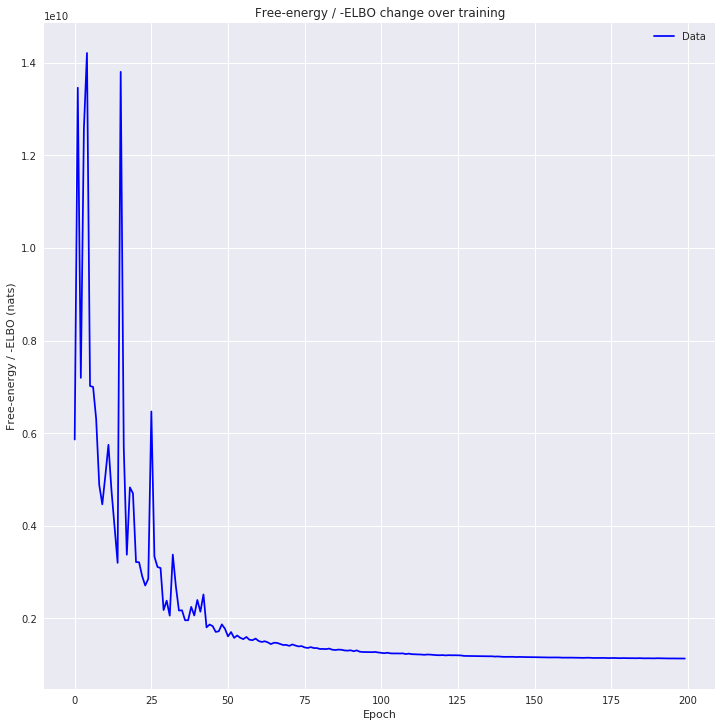

03/14/2018 13:44:56 Reconstruction Error (Frobenius Norm): 4.84243896e+03
03/14/2018 13:44:56 {'weights': array([[-0.3448151 ,  1.769684  ,  0.7900213 , ...,  0.6282081 ,
        -1.794164  ,  0.74337006],
       [-1.1537013 ,  0.662029  ,  1.8755388 , ...,  0.36710304,
         0.22311951,  1.2110517 ],
       [-2.0835886 ,  0.01092681,  1.6048523 , ..., -1.381148  ,
         1.0308353 ,  1.7851113 ],
       ...,
       [-4.2416987 ,  0.32883608,  1.1612865 , ..., -0.7889446 ,
         0.29773322,  0.40575516],
       [-4.7304015 ,  0.15581176,  2.3455226 , ..., -0.12259816,
        -0.0920226 , -0.9059255 ],
       [-5.664709  ,  0.6635033 ,  4.0384254 , ...,  2.2033353 ,
         0.88182026, -2.2980847 ]], dtype=float32), 'factors': array([[2.8926299e-03, 3.0820265e-03, 3.2631699e-03, ..., 2.8102330e-03,
        3.1492333e-03, 3.3242078e-03],
       [6.3691834e-05, 6.1828985e-05, 5.9414157e-05, ..., 5.6317091e-01,
        5.9296930e-01, 5.4564852e-01],
       [2.0689773e-04, 2.06581

In [5]:
utils.plot_losses(losses)

results = tfa.results()
logging.info(results)

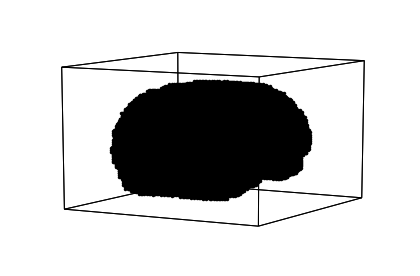

03/14/2018 13:44:56 Reconstruction Error (Frobenius Norm): 4.84287744e+03


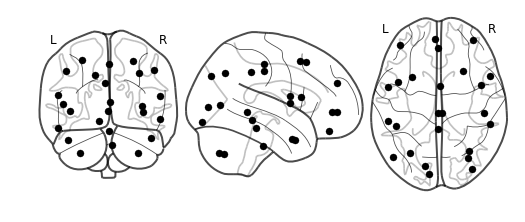

In [6]:
tfa.plot_voxels()
tfa.plot_factor_centers()

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


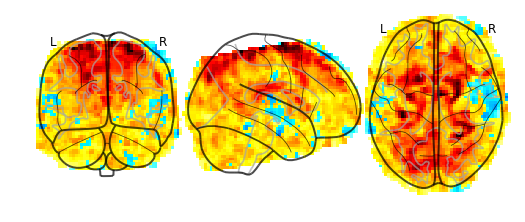

03/14/2018 13:44:57 Reconstruction Error (Frobenius Norm): 4.84703271e+03


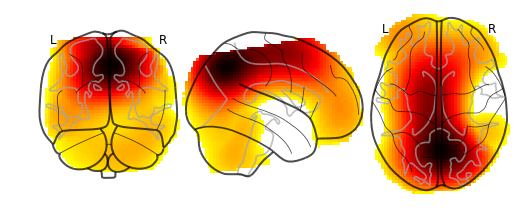

In [7]:
tfa.plot_original_brain()
tfa.plot_reconstruction()

03/14/2018 13:45:11 Reconstruction Error (Frobenius Norm): 4.85169141e+03


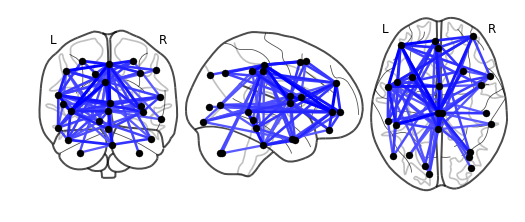

In [8]:
tfa.plot_connectome()